In [479]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.io
from scipy import signal
from scipy.optimize import curve_fit
from ipywidgets import interact, widgets, fixed
from IPython.display import display, Latex, Math

# %matplotlib

duch_roll_data = scipy.io.loadmat("data_2024/Dutch-Roll.mat")
phugoid_data = scipy.io.loadmat("data_2024/Phugoid.mat")
roll_rub_data = scipy.io.loadmat("data_2024/Roll-Subs.mat")
spiral_data =  scipy.io.loadmat("data_2024/Spiral.mat")
SPO_data =  scipy.io.loadmat("data_2024/SPPO.mat")

duch_roll_data['Name'] = "Duch Roll"
phugoid_data['Name'] = "Phugoid"
roll_rub_data['Name'] = "Roll Subsidance"
spiral_data['Name'] = "Spiral"
SPO_data['Name'] = "SPO"

print_better = lambda stuff: print("\n".join(list(map(str, stuff))), "\n")

def secondOrd(t0,B,peak,period,zeta,t, phi=0):
    # t0,B,peak,period,zeta,t
    
    psim = np.atan(np.sqrt(1-zeta**2)/zeta)
    A = (peak - B)/(np.sqrt(1-zeta**2) * np.exp(-zeta*psim/np.sqrt(1-zeta**2)))

    omd = 2*np.pi/period
    omn = omd/np.sqrt(1-zeta**2)

    display(Math(f"\\omega_n = {omn:.3f} \\space rads/s \\quad \\omega_d = {omd:.3f} \\space rads/s \\quad \\zeta = {zeta:.3f}"))

    return A * np.exp(-zeta*omn*(t-t0)) * np.sin(omd*(t-t0)+phi)  +  B

# def secondOrd(t0,B,A,period,zeta,t):
#     psim = np.atan(np.sqrt(1-zeta**2)/zeta)
#     # A = (peak - B)/(np.sqrt(1-zeta**2) * np.exp(-zeta*psim/np.sqrt(1-zeta**2)))

#     omd = 2*np.pi/period
#     omn = omd/np.sqrt(1-zeta**2)

#     return A * np.exp(-zeta*omn*(t-t0)) * np.sin(omd*(t-t0))  +  B


def gauss_smooth(data, window_size=5, sigma=1):
    x = np.linspace(-1, 1, window_size)
    # print(data.shape, x.shape)
    kernel = 1/(sigma*np.sqrt(2*np.pi))*np.exp(-0.5*(x/sigma)**2)
    kernel /= np.sum(kernel)
    padded_data = np.pad(data, window_size, "edge")
    # print(np.convolve(kernel, data[:, 0],  mode="same"))
    return np.convolve(kernel, padded_data,  mode="same")[window_size:-window_size]

def plot_all(data, smooth=True, exclude:list=[None], start=0, end=None, peak=False, window=50, norm=True):
    t_true = data['Time']
    if end is None : end = t_true[-1]
    try:
        start_i = np.where(start <= t_true)[0][0]
        end_i = np.where(t_true <= end)[0][-1]
    except IndexError:
        print("Invalid start or end")
        return 
    t = t_true[start_i:end_i].flatten()

    for key in data:
        if key not in  ["Time", "Name", '__header__', '__version__', '__globals__', "EAS", *exclude]:
            if norm:
                norm_data = (data[key]-data[key][0])/np.max(np.abs(gauss_smooth((data[key]-data[key][0])[:, 0], window_size=30)))
                norm_data = norm_data[start_i:end_i].flatten()
            else:
                norm_data = data[key][start_i:end_i].flatten()
            plt.plot(t, norm_data, label=key)

            if smooth:
                plt.plot(t, gauss_smooth(norm_data, window_size=window), label=f"smooth {key}")
            
    plt.title(data["Name"])
    plt.legend()
    plt.ylabel("Normalised vals")
    plt.xlabel("time (s)")
    plt.show()

def plot_one(data, key, show=True, smooth=True, start=0, end=None, norm=True, sigma=1, window=50, both=True):
    t_true = data['Time']
    if end is None : end = t_true[-1]
    try:
        start_i = np.where(start <= t_true)[0][0]
        end_i = np.where(t_true <= end)[0][-1]
    except IndexError:
        print("Invalid start or end")
        return 
    
    if norm:
        norm_data = (data[key]-data[key][0])/np.max(np.abs(data[key]-data[key][0]))
    else:
        norm_data = data[key][:]
        
    t = t_true[start_i:end_i].flatten()
    norm_data = norm_data[start_i:end_i].flatten()

    if both:
        plt.plot(t, norm_data, label=f"{key}")
        plt.plot(t, gauss_smooth(norm_data, window_size=window, sigma=sigma), label=f"smooth {key}")
    else:
        if smooth: 
            plt.plot(t, gauss_smooth(norm_data, window_size=window, sigma=sigma), label=f"smooth {key}")
        else:
            plt.plot(t, norm_data, label=f"{key}")


    plt.title(key)
    plt.ylabel("Normalised val")
    plt.xlabel("time (s)")
    plt.legend()
    if show: plt.show()

def plot_guess(data, key, p0, phi=0, start=0, end=None, show=True):
    t_true = data['Time']
    if end is None : end = t_true[-1]
    try:
        start_i = np.where(start <= t_true)[0][0]
        end_i = np.where(t_true <= end)[0][-1]
    except IndexError:
        print("Invalid start or end")
        return 
    t = t_true[start_i:end_i].flatten()

    plt.plot(t, secondOrd(start,*p0,t, phi=phi), label="simulated")
    if show:
        plt.legend()
        plt.show()

def freq_analysis(data, key, start=0, end=None, window_size=30, plot = True, show=True, debug=False, x_range=None, ignore_first=0, down_samp=1):
    t_true = data['Time']
    if end is None : end = t_true[-1]
    try:
        start_i = np.where(start <= t_true)[0][0]
        end_i = np.where(t_true <= end)[0][-1]
    except IndexError:
        print("Invalid start or end")
        return 
    t = t_true[start_i:end_i].flatten()
    data_n = data[key][start_i:end_i].flatten()

    T= np.mean(np.diff(t, axis=0))
    fft_domain = np.fft.fft(gauss_smooth(data_n, window_size=window_size)[::down_samp])
    freq = np.fft.fftfreq(len(fft_domain), d=T*down_samp)
    n = ignore_first
    L = len(fft_domain)
    freq_out = np.mean(abs(freq[1+signal.find_peaks(abs(fft_domain[1::]), height=np.max(abs(fft_domain[1:])))[0]]))

    if debug:
        plt.plot(freq[1:], abs(fft_domain[1:]))
        if x_range is not None: plt.xlim(-x_range, x_range)
        if show: plt.show()

    if plot:
        plot_one(data, key, show=show, start=14, norm=False)

    return freq_out

def print_peak(res_tuple):
    zeta, T, var_z, var_t, size_z, size_t   = res_tuple
    omegan = 2*np.pi/(np.sqrt(1-zeta**2)*T)
    return display(Math(f"\\zeta = {zeta:.3f} \\qquad  \\omega_n = {omegan:.3f} \\quad rads/s"))

def peak_method(data, key, start, end, smooth_window_size=30, sigma=1):
    t_true = data['Time']
    if end is None : end = t_true[-1]
    try:
        start_i = np.where(start <= t_true)[0][0]
        end_i = np.where(t_true <= end)[0][-1]
    except IndexError:
        print("Invalid start or end")
        return 
    t = t_true[start_i:end_i].flatten()
    data_n = data[key][start_i:end_i].flatten()

    peaks = signal.find_peaks(gauss_smooth(data_n, window_size=smooth_window_size, sigma=sigma))[0]
    peaks_neg = signal.find_peaks(-gauss_smooth(data_n, window_size=smooth_window_size, sigma=sigma))[0]

    # plt.plot(gauss_smooth(data_n, window_size=30))
    # plt.plot(-gauss_smooth(data_n, window_size=30))
    # plt.show()

    # print(t[peaks], t[peaks_neg])

    comb_peaks = np.zeros(peaks.shape[0]+peaks_neg.shape[0], dtype=int)

    if peaks[0] > peaks_neg[0]:
        comb_peaks[::2] = peaks_neg
        comb_peaks[1::2] = peaks
    else:
        comb_peaks[::2] = peaks
        comb_peaks[1::2] = peaks_neg

    # print(comb_peaks)

    vals = np.zeros(comb_peaks.shape[0]-1)
    ts = np.zeros(comb_peaks.shape[0]-1)
    for i in range(comb_peaks.shape[0]-1):
        vals[i] = np.abs(data_n[comb_peaks[i]]-data_n[comb_peaks[i+1]])
        ts[i] = t[comb_peaks[i+1]] - t[comb_peaks[i]]
    # vals = np.abs(np.diff(data_n[comb_peaks]))
    tprs = vals[1:]/vals[:-1]
    tpr = np.mean(tprs)
    period = 2*np.mean(ts)
    # print(tpr)
    # print(2*np.mean(ts))

    zeta = 1/(np.sqrt(1+(np.pi/np.log(tpr))**2))
    # print(ts.shape, tprs.shape)

    return zeta, period, np.var(2*ts), np.var(tprs), ts.shape, tprs.shape
    

def cost_func(sim_data, real_data):
    pass

def func(t, B, A, freq, phi, one_over_tau):
    return B + A*np.exp(-t*one_over_tau)*np.sin(2*np.pi*freq*t + phi)

def guess(data, key, start=0, end=None, debug=False, x_range=0.5):
    t_true = data['Time']
    if end is None : end = t_true[-1]
    try:
        start_i = np.where(start <= t_true)[0][0]
        end_i = np.where(t_true <= end)[0][-1]
    except IndexError:
        print("Invalid start or end")
        return 
    t = t_true[start_i:end_i].flatten()

    freq_out = freq_analysis(data, key, start=start,end=end, show=debug, debug=debug, plot=debug, x_range=x_range)
    if debug: print(freq_out)

    data_n = data[key][start_i:end_i].flatten()

    B = np.mean(gauss_smooth(data_n)) #/(t[-1]-14)*(t[1]-t[0])
    if debug: print(B)

    # B-=s1.3
    peaks = signal.find_peaks(gauss_smooth(data_n, window_size=30))[0]
    peaks_neg = signal.find_peaks(-gauss_smooth(data_n, window_size=30))[0]

    valid_peak = peaks
    ng_valid_peak=peaks_neg
    # for i in range(peaks.shape[0]):
    #     if start <= t[peaks_neg[i]] <= end: valid_peak.append(peaks[i])

    # ng_valid_peak = []
    # for i in range(peaks_neg.shape[0]):
    #     if start <= t[peaks_neg[i]] <= end: ng_valid_peak.append(peaks_neg[i])
    # valid_peak.sort()
    # valid_peak = np.array(valid_peak[:])
    # print(duch_roll_data["Rollang"][valid_peak])
    # plt.yscale("log")
    # print(t.flatten().shape)
    coef = np.polyfit(t[valid_peak].flatten(), np.log(data[key][valid_peak].flatten()), deg=1)
    func = np.poly1d(coef)

    p0 = [B, data[key][min(valid_peak[0], abs(ng_valid_peak[0]))], 1/freq_out, -coef[0]/(freq_out*2*np.pi)]

    if debug:
        plt.plot(t, secondOrd(start,*p0,t), label="simulated")
        plt.legend()
        plt.show()

    if debug:
        plt.plot(t[valid_peak], np.log(data[key][valid_peak]), 'x')
        plt.plot(t, func(t))
        plt.show()


    print(f"peak={coef[1]}, 1/tau = {coef[0]}")
    print(f"first peak = {data[key][valid_peak[0]]}")
    return p0

def exp_decay(t, B, A, tau, t0):
    y = B + A*(1-np.exp(-(t-t0)/tau))
    y[t<t0] = B
    display(Math(f"T_r = {tau} \\space s"))
    return y

def func(t, B, A, freq, phi, one_over_tau):
    return B + A*np.exp(-t*one_over_tau)*np.sin(2*np.pi*freq*t + phi)


# key = "EAS"
# gauss_smooth(duch_roll_data[key]/duch_roll_data[key][0])

# plot_all(duch_roll_data, start=14, end=22)


# Dutch Roll
Dutch roll is an oscillatory mode causing the aircraft to yaw and sideslip.
It is very weekly damped and the side slips from the Dutch roll induce a change in roll angle so we can observe the oscillation in Roll angle and Roll rate with different damping ratios due to the dihedral effect
this gives the Dutch roll its characteristic elliptical rotation of wingtips.


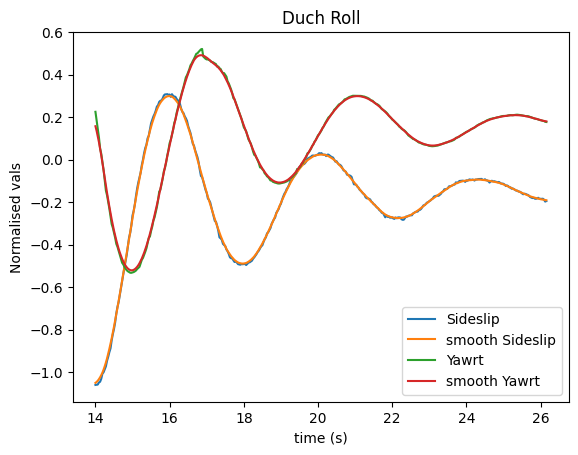

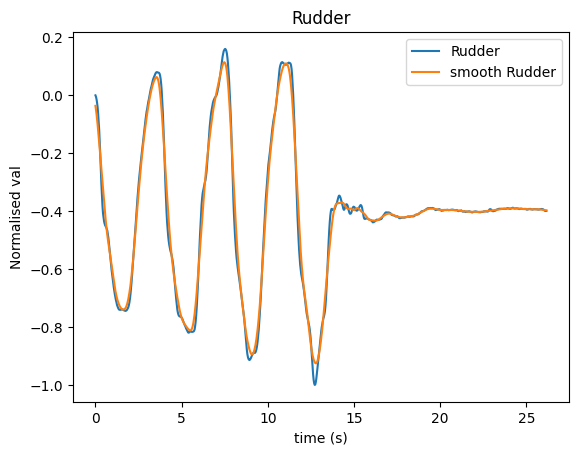

<IPython.core.display.Latex object>

<IPython.core.display.Math object>

<IPython.core.display.Latex object>

<IPython.core.display.Math object>

In [480]:
plot_all(duch_roll_data, start = 14, exclude=["Rudder", "Rollang", "Rollrt"], smooth=True, window=15) #, "Rollang", "Rollrt"
plot_one(duch_roll_data, 'Rudder', both=True, window=20, sigma=5)

display(Latex("Sideslip"))
# print(freq_analysis(duch_roll_data, "Sideslip", start=14, end=22, show=False, plot=False))
print_peak(peak_method(duch_roll_data, "Sideslip", start=14, end=22, smooth_window_size=15))

display(Latex("Yaw rate"))
# print(freq_analysis(duch_roll_data, "Yawrt", start=14, end=22, show=False, plot=False, window_size=100))
print_peak(peak_method(duch_roll_data, "Yawrt", start=14, end=22, smooth_window_size=15))

The frequency and the damping rate are measured using the Transient Peak Ratio (TPR) method.
For better accuracy, a Gaussian filter is applied to the signal to smooth out any high-frequency noise present in the signal before finding the peak. (This is done for Dutch roll as well.)
This gives a frequency of $4.08Hz$ averaged from slideslipt and Yaw rate.
The damping ratio ($\zeta$) is $0.140$ respectively.
This result is reliable since all four frequencies calculated from side slip, yaw rate, roll angle, and roll rate give similar results.
Equally, the independently calculated damping ratio from the yaw rate and slide slip is also similar thus this data is quite reliable.


The resonant frequency can also be obtained from the Roll angle and Roll rate using the same method.
However, the damping rate is different and the Rolling motion is better damped than the yawing and sideslip in the Dutch roll.

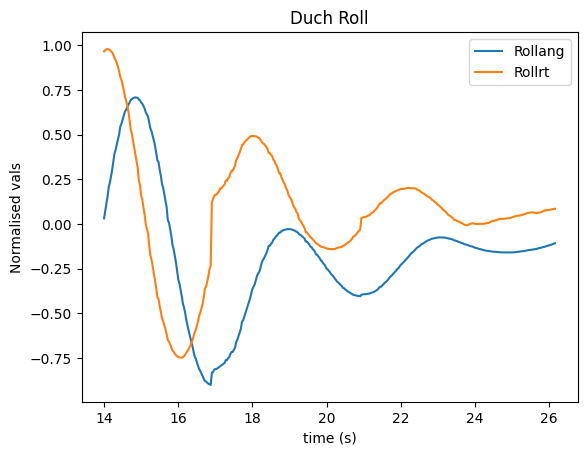

<IPython.core.display.Latex object>

<IPython.core.display.Math object>

<IPython.core.display.Latex object>

<IPython.core.display.Math object>

In [481]:
plot_all(duch_roll_data, start = 14, exclude=["Rudder", "Sideslip", "Yawrt"], smooth=False) #, "Rollang", "Rollrt"

display(Latex("Roll angle"))
# print(freq_analysis(duch_roll_data, "Rollang", start=14, end=22, show=False, plot=False))
print_peak(peak_method(duch_roll_data, "Rollang", start=14, end=22))

display(Latex("Roll rate"))
# print(freq_analysis(duch_roll_data, "Rollrt", start=14, end=22, show=False, plot=False))
print_peak(peak_method(duch_roll_data, "Rollrt", start=14, end=22))

# Phugoid
Phugoid motion is a lightly damped low-frequency oscillatory mode that takes around 40 seconds to present and can be easily corrected but is quite difficult to detect in bad visibility.
Phugoid mode presents itself in the oscillation in airspeed, AOA (and thus pitch rate), Altitude and vertical acceleration.
The data For the Angle of attack is heavily dependent on the elevator and the altitude data seems corrupted so effective airspeed (EAS), downward acceleration and pitch rate are used to calculate the resonant frequency and damping. 

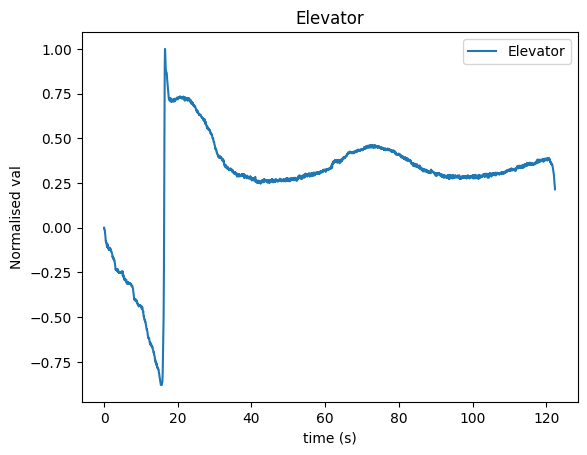

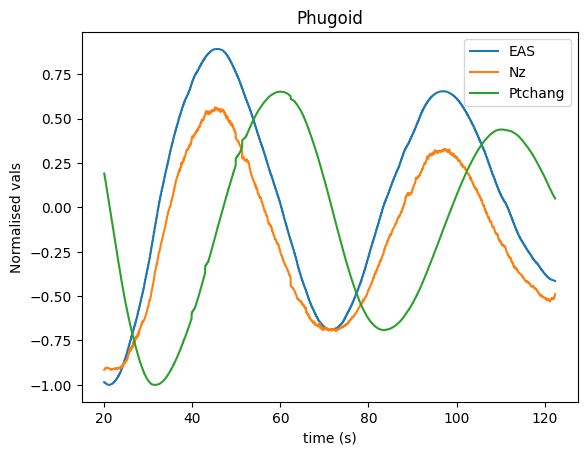

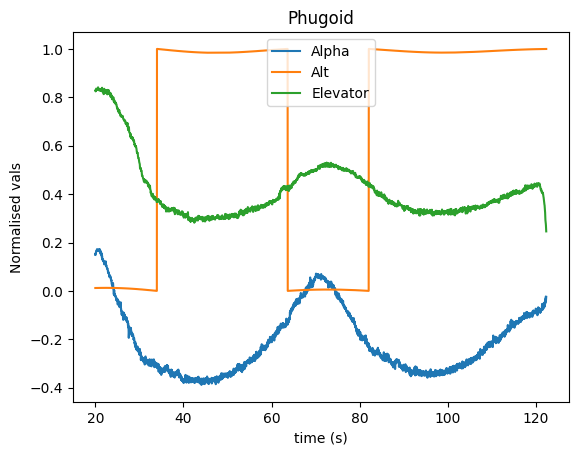

<IPython.core.display.Latex object>

<IPython.core.display.Math object>

<IPython.core.display.Latex object>

<IPython.core.display.Math object>

<IPython.core.display.Latex object>

<IPython.core.display.Math object>

In [482]:
plot_one(phugoid_data, "Elevator", start=0, smooth=False, both=False)

plot_one(phugoid_data, "EAS", start=20, show=False, smooth=False, both=False)
plot_all(phugoid_data, start=20, smooth=False, exclude=["Alpha", "Alt", "Elevator"])

# plot_all(phugoid_data, start=20, smooth=False)

plot_all(phugoid_data, start=20, smooth=False, exclude=["Nz", "Ptchang"])

display(Latex("Effective Air Speed"))
print_peak(peak_method(phugoid_data, "EAS", start=20, end=None))

display(Latex("Nz (acceleration in z direction)"))
print_peak(peak_method(phugoid_data, "Nz", start=20, end=None, smooth_window_size=300))

display(Latex("Pitch angle"))
print_peak(peak_method(phugoid_data, "Ptchang", start=20, end=None))

Average:

$\displaystyle \zeta = 0.061 \qquad  \omega_n = 0.122 \quad rads/s$

# Short Period Oscillaion (SPO)
Short-period oscillation is an oscillation mode with a very small time constant and higher frequency present in pitch angle (and thus pitch rate).
SPO is well-damped and thus only presents itself when there is impulse.
The unformed oscillation after the impulse is used to fit a decaying sinusoid to estimate the natural frequency, along with the damping ratio.
$$y=Ae^{-\zeta\omega_n(t-t_0)}\sin[\omega_d(t-t_0)] + B$$
is used to bit the curve. (where $\omega_n = \omega_d/\sqrt{1-\zeta^2}$)


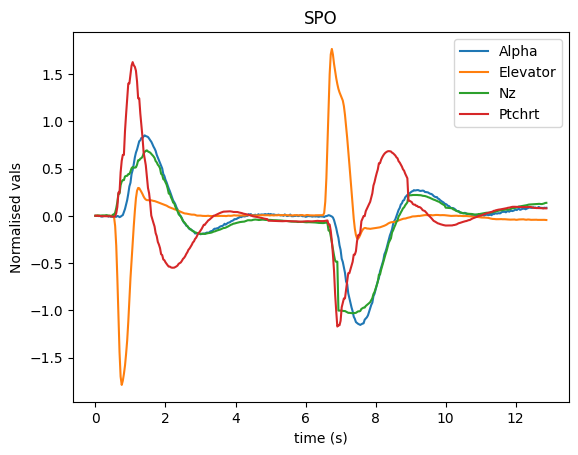

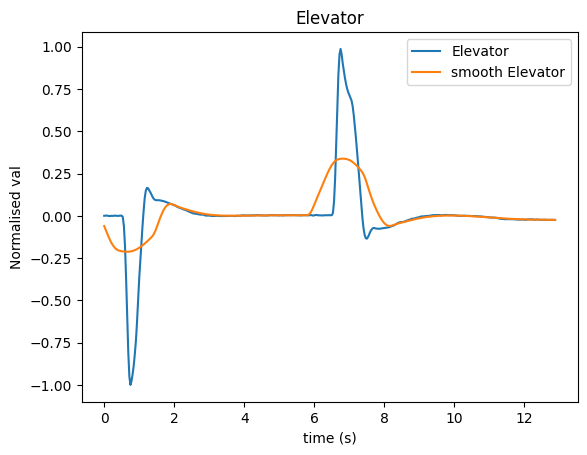

In [483]:
plot_all(SPO_data, smooth=False)
plot_one(SPO_data, "Elevator", smooth=False)

<IPython.core.display.Math object>

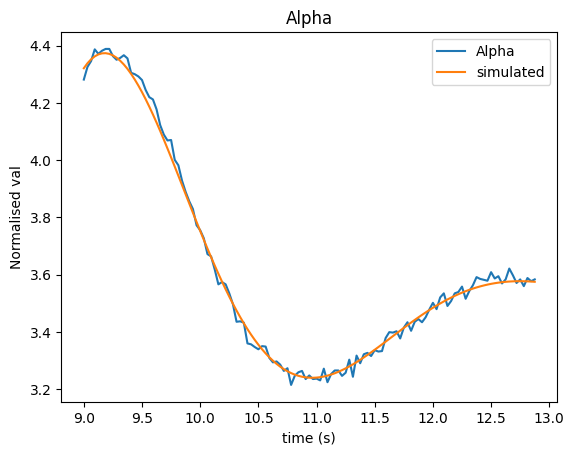

In [484]:
data = SPO_data
key = "Alpha"
start = 9

# p0 = list(guess(data, key, start=start, debug=True, x_range=1))
p0 = np.zeros(4)

def trial_and_error(B, peak, period, zeta, phi):
    p= [B, peak, period, zeta]
    plot_one(data, key, show=False, start=start, norm=False, window=25, smooth=False, both=False)
    plot_guess(data, key, p,phi=phi, start=start)

p0[0]=3.50 # 3.46
p0[1]=4.12 # 4.03
p0[2]=3.57 # 3.89
p0[3]=0.36 # 0.41

phi=0.89

# B = widgets.FloatSlider(value=p0[0], min=3, max=4.5, step=0.01)
# peak = widgets.FloatSlider(value=p0[1], min=3, max=4.5, step=0.01)
# period = widgets.FloatSlider(value=p0[2], min=0, max=10, step=0.001)
# zeta = widgets.FloatSlider(value=p0[3], min=0, max=1, step=0.01)
# phi=widgets.FloatSlider(value=phi, min=-2*np.pi, max=2*np.pi, step=0.01)
# print(p0[2])

# interact(trial_and_error, B=B, peak=peak, period=period, zeta=zeta, phi=phi)
trial_and_error(p0[0], p0[1], p0[2], p0[3], phi)
# print_speak((p0[3], p0[]))


<IPython.core.display.Math object>

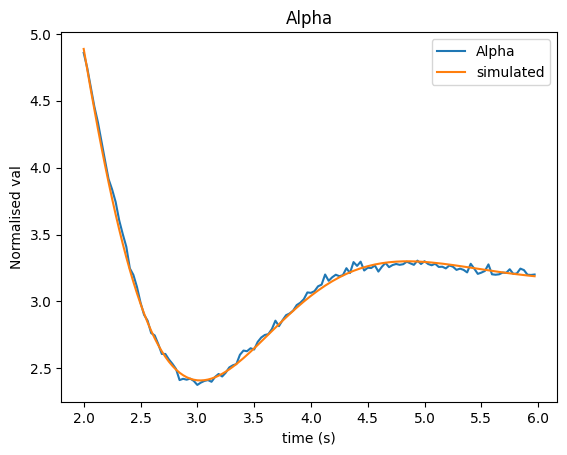

In [485]:
data = SPO_data
key = "Alpha"
start = 2
end=6

# p0 = list(guess(data, key, start=start, debug=True, x_range=1))

def trial_and_error(B, peak, period, zeta, phi):
    p= [B, peak, period, zeta]
    plot_one(data, key, show=False, start=start, end=end, norm=False, window=25, smooth=False, both=False)
    plot_guess(data, key, p,phi=phi, start=start, end=end)

p0[0]=3.18 # 3.46
p0[1]=4.37 # 4.03
p0[2]=3.65 # 3.89
p0[3]=0.51 # 0.41

phi=2.41

# B = widgets.FloatSlider(value=p0[0], min=3, max=4.5, step=0.01)
# peak = widgets.FloatSlider(value=p0[1], min=3, max=5, step=0.01)
# period = widgets.FloatSlider(value=p0[2], min=0, max=10, step=0.001)
# zeta = widgets.FloatSlider(value=p0[3], min=0, max=1, step=0.01)
# phi=widgets.FloatSlider(value=phi, min=-2*np.pi, max=2*np.pi, step=0.01)
# print(p0[2])

# interact(trial_and_error, B=B, peak=peak, period=period, zeta=zeta, phi=phi)
trial_and_error(p0[0], p0[1], p0[2], p0[3], phi)

Average:

$\displaystyle \omega_n = 1.9435\space rads/s \quad \omega_d = 1.741\space rads/s \quad \zeta = 0.435$

# Spiral Mode
The spiral mode in the test plane is a mode with either an exponentially decaying or growing roll angle due to the engine configuration.
When the aircraft slowly banks this causes sideslip, and depending on the combined effect of the dihedral, the yawing moment and the engine which oppose each other usually create a small rolling moment in the direction of the roll for unstabel side and cause the aircraft to further bank. If left unattended the aircraft will decent and rotate causing it to spiral.
However the time constant for this mode is large so it can be corrected easily before growing larger.

the roll angle of unstabe spiral mode is modeled with :
$$ s(t) = \bar{s} + s_0e^{-(t-t_0)/\tau}$$

So by removing $\bar{s}$ and by taking log:
$$ log(s(t) - \bar{s}) = s_0 -(t-t_0)/\tau$$

thus the inverse of the gradient to this dat agives the time constant.

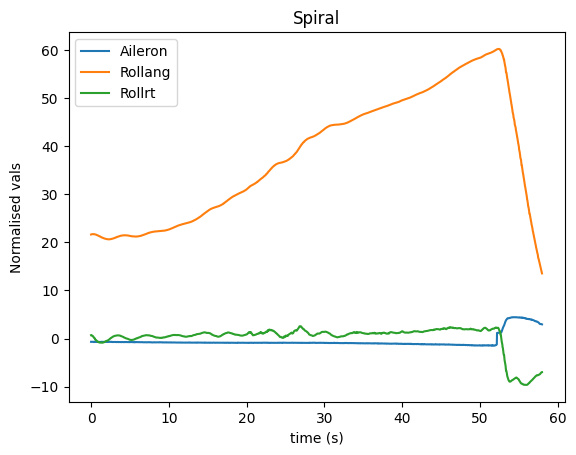

In [486]:
plot_all(spiral_data, start=0, norm=False, smooth=False)
# plot_one(spiral_data, "Aileron", start=0, end=50)
# plot_one(spiral_data, "EAS", start=0, end=50)

<IPython.core.display.Math object>

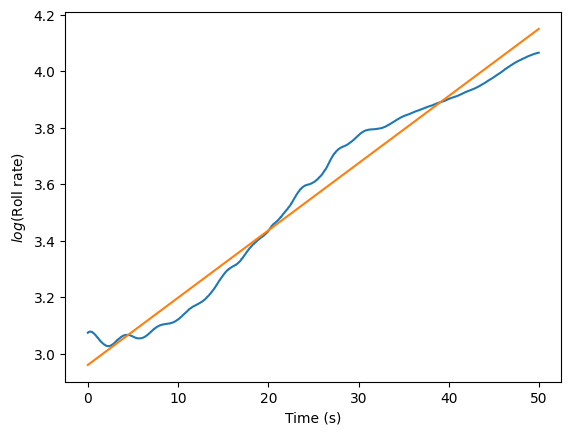

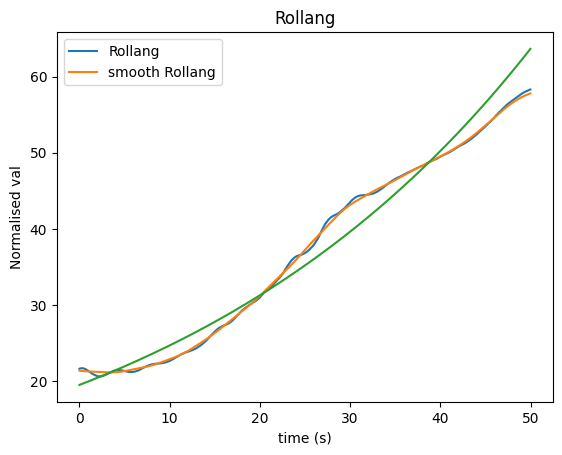

In [487]:
# this is just wrong
data = spiral_data
key = "Rollang"
start = 0
end = 50

# p0 = list(guess(data, key, start=start, debug=True, x_range=1))

def exp_growth(t, B, A, tau, t0):
    y = B + A*(np.exp((t-t0)/tau)-1)
    # y[t<t0] = B
    return y

def trial_and_error(B, A, tau, t0):
    start = 0
    end = 50
    plot_one(data, key, show=False, start=start, end=end, norm=False, window=200)
    # plot_guess(data, key, p,phi=phi, start=start, end=end)
    t_true = data['Time']
    if end is None : end = t_true[-1]
    try:
        start_i = np.where(start <= t_true)[0][0]
        end_i = np.where(t_true <= end)[0][-1]
    except IndexError:
        print("Invalid start or end")
        return 
    t = t_true[start_i:end_i].flatten()
    plt.plot(t, exp_growth(t,B, A, tau, t0))
    # plt.ylim(0, 6.5)
    plt.show()

t_true = data['Time']
if end is None : end = t_true[-1]
try:
    start_i = np.where(start <= t_true)[0][0]
    end_i = np.where(t_true <= end)[0][-1]
except IndexError:
    print("Invalid start or end")
t = t_true[start_i:end_i].flatten()
data_n =data[key][start_i:end_i].flatten()
# smoothed_data_n = gauss_smooth(data_n, window_size=100)
# data_n -= 20

coef = np.polyfit(t, np.log(data_n), deg=1)
func = np.poly1d(coef)

display(Math(f"s_0 = {np.exp(coef[-1]):.3f} \\quad \\tau = {1/coef[0]:.3f}"))

plt.plot(t, np.log(data_n))
# plt.plot(t, np.log(smoothed_data_n))
plt.plot(t, func(t))
plt.xlabel("Time (s)")
plt.ylabel(r"$log(\text{Roll rate})$")
plt.show()

B = 19.51 # 16.45
A = 19.298398640851886 # 16.108573013976965 
tau = 42.000699147756045 # 30.08815638051047
t0 = 0

# B = widgets.FloatSlider(value=B, min=15, max=25, step=0.01)
# A = widgets.FloatSlider(value=A, min=1, max=25, step=0.01)
# tau = widgets.FloatSlider(value=tau, min=20, max=100, step=0.001)
# t0 = widgets.FloatSlider(value=t0, min=0, max=5, step=0.01)
# print(p0[2])

# interact(trial_and_error, B=B,A=A, tau=tau, t0=t0)
trial_and_error(B, A, tau, t0)

The line fitting for this data is not very good due to possibly a disterbance in the system.
A much better fit can be obtained if only data from 0-30 seconds is used however 

# Roll subsidence

Roll subsidence is a stable mode present as a lag in the Roll rate with respect to the pilot demand.
It can be modeled with: 
$$ s(t) = \bar{s} + s_0 (1 - e^{t/Tr})$$
The step response of roll rate is used to estimate the time constant associated with this mode.

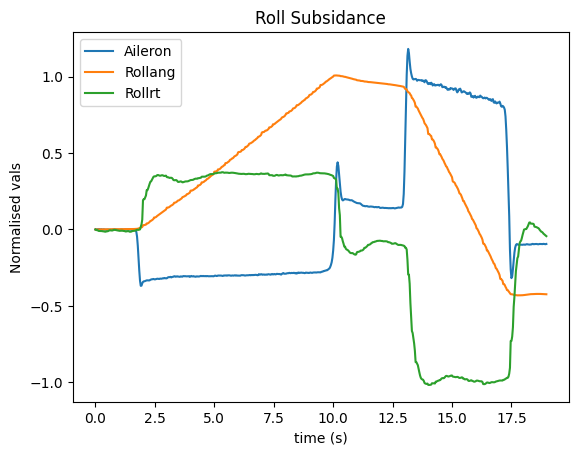

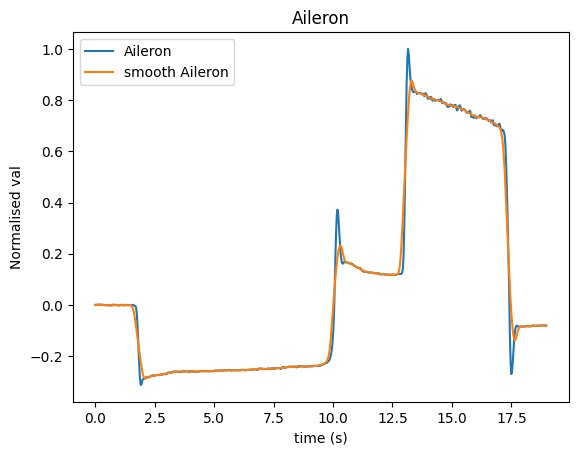

In [488]:
plot_all(roll_rub_data, smooth=False)
plot_one(roll_rub_data, "Aileron", both=True, window=15)

<IPython.core.display.Math object>

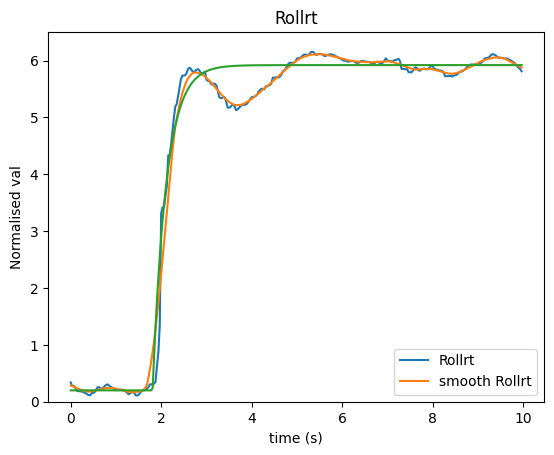

In [489]:
data = roll_rub_data
key = "Rollrt"

# p0 = list(guess(data, key, start=start, debug=True, x_range=1))

def trial_and_error(B, A, tau, t0):
    start = 0
    end = 10
    plot_one(data, key, show=False, start=start, end=end, norm=False, window=20, smooth=False)
    # plot_guess(data, key, p,phi=phi, start=start, end=end)
    t_true = data['Time']
    if end is None : end = t_true[-1]
    try:
        start_i = np.where(start <= t_true)[0][0]
        end_i = np.where(t_true <= end)[0][-1]
    except IndexError:
        print("Invalid start or end")
        return 
    t = t_true[start_i:end_i].flatten()
    plt.plot(t, exp_decay(t,B, A, tau, t0))
    plt.ylim(0, 6.5)
    plt.show()

B = 0.2
A = 5.72
tau = 0.30
t0 = 1.81

# B = widgets.FloatSlider(value=B, min=0, max=6, step=0.01)
# A = widgets.FloatSlider(value=A, min=1, max=6, step=0.01)
# tau = widgets.FloatSlider(value=tau, min=0, max=1, step=0.001)
# t0 = widgets.FloatSlider(value=t0, min=-2, max=2, step=0.01)
# print(p0[2])

# interact(trial_and_error, B=B,A=A, tau=tau, t0=t0)
trial_and_error(B, A, tau, t0)

<IPython.core.display.Math object>

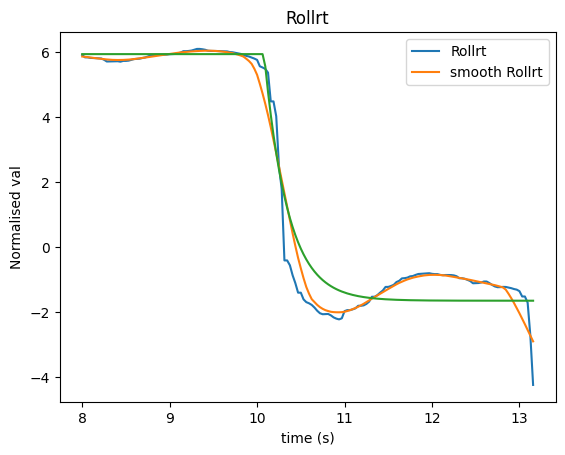

In [490]:
data = roll_rub_data
key = "Rollrt"

# p0 = list(guess(data, key, start=start, debug=True, x_range=1))

def trial_and_error(B, A, tau, t0):
    start = 8
    end = 13.2
    plot_one(data, key, show=False, start=start, end=end, norm=False, window=20, smooth=False)
    # plot_guess(data, key, p,phi=phi, start=start, end=end)
    t_true = data['Time']
    if end is None : end = t_true[-1]
    try:
        start_i = np.where(start <= t_true)[0][0]
        end_i = np.where(t_true <= end)[0][-1]
    except IndexError:
        print("Invalid start or end")
        return 
    t = t_true[start_i:end_i].flatten()
    plt.plot(t, exp_decay(t,B, A, tau, t0))
    # plt.ylim(0, 6.5)
    plt.show()

B = 5.95
A = -7.6
tau = 0.27
t0 = 10.08

# B = widgets.FloatSlider(value=B, min=0, max=6, step=0.01)
# A = widgets.FloatSlider(value=-A, min=-10, max=0, step=0.01)
# tau = widgets.FloatSlider(value=tau, min=0, max=1, step=0.001)
# t0 = widgets.FloatSlider(value=t0, min=8, max=13, step=0.01)
# print(p0[2])

# interact(trial_and_error, B=B,A=A, tau=tau, t0=t0)
trial_and_error(B, A, tau, t0)

<IPython.core.display.Math object>

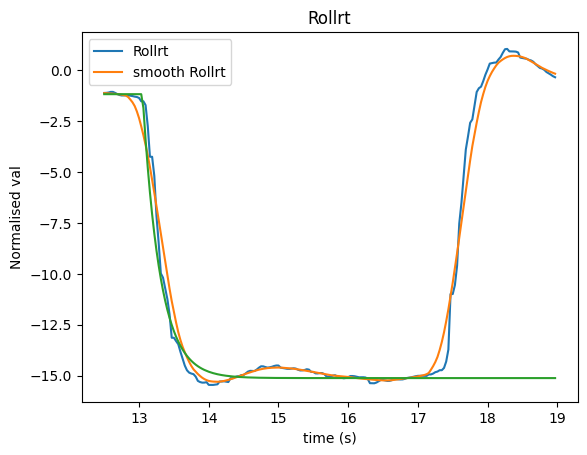

In [491]:
data = roll_rub_data
key = "Rollrt"
start = 12.5
end = None

# p0 = list(guess(data, key, start=start, debug=True, x_range=1))

def trial_and_error(B, A, tau, t0):
    start = 12.5
    end = None
    plot_one(data, key, show=False, start=start, end=end, norm=False, window=20, smooth=False)
    # plot_guess(data, key, p,phi=phi, start=start, end=end)
    t_true = data['Time']
    if end is None : end = t_true[-1]
    try:
        start_i = np.where(start <= t_true)[0][0]
        end_i = np.where(t_true <= end)[0][-1]
    except IndexError:
        print("Invalid start or end")
        return 
    t = t_true[start_i:end_i].flatten()
    plt.plot(t, exp_decay(t,B, A, tau, t0))
    # plt.ylim(, 6.5)
    plt.show()

B = -1.17
A = -13.95
tau = 0.25
t0 = 13.05

# B = widgets.FloatSlider(value=B, min=-15, max=0, step=0.01)
# A = widgets.FloatSlider(value=A, min=-15, max=0, step=0.01)
# tau = widgets.FloatSlider(value=tau, min=0, max=1, step=0.001)
# t0 = widgets.FloatSlider(value=t0, min=12, max=14, step=0.01)
# print(p0[2])

# interact(trial_and_error, B=B,A=A, tau=tau, t0=t0)
trial_and_error(B, A, tau, t0)

3 step responses are used to estimate the time constant $T_r$ the last step resonse is not used since it could not be fit very well as the responce does not fully settle.

Averaged $T_r = 0.27$

The accuracy of this time constant is low since the line fitting is done somewhat qualitatively so there is a large factor of measuement error.